## Github Issue: https://github.com/dmwm/CRABServer/issues/7313

### This notebook defines the schema and the usage/ manipulation of each column of the datasource to be stored in the database. Aim for minimum schema to answer the following questions (can add more):
- cpueff/walltime/failure rate of jobs BY input data tier/site/mc production/offsite vs onsite

## schema

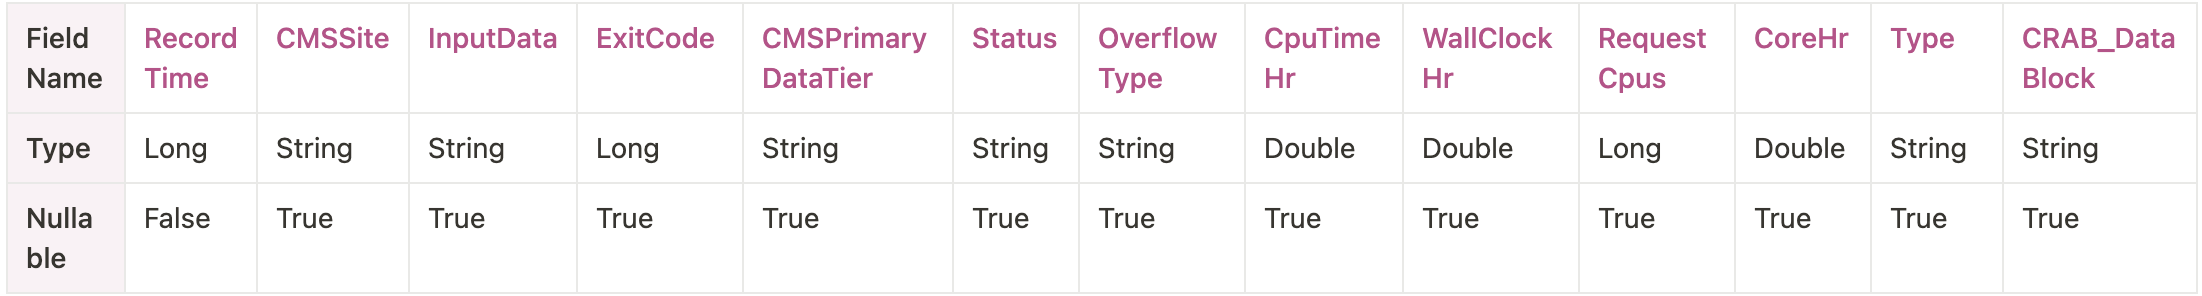

In [39]:
#Possible (minimum) schema for the first datasource:
def _get_schema():
    return StructType(
        [
            StructField(
                "data",
                StructType(
                    [
                        StructField("RecordTime", LongType(), nullable=False), #Could store as YYYY:MM:DD or HH YYYY:MM:DD
                        StructField("CMSSite", StringType(), nullable=True),
                        StructField("InputData", StringType(), nullable=True), #['Onsite', 'Offsite']
                        StructField("ExitCode", LongType(), nullable=True), #Not manipulated yet
                        StructField("CMSPrimaryDataTier", StringType(), nullable=True),
                        StructField("Status", StringType(), nullable=True), #Only includes ['Removed','Completed','Held','Error']
                        StructField("OverflowType", StringType(), nullable=True),
                        StructField("CpuTimeHr", DoubleType(), nullable=True),
                        StructField("WallClockHr", DoubleType(), nullable=True),
                        StructField("RequestCpus", LongType(), nullable=True),
                        StructField("CoreHr", DoubleType(), nullable=True), #CoreHr=WallClockHr*RequestCpus
                        StructField("Type", StringType(), nullable=True),
                        StructField("CRAB_DataBlock", StringType(), nullable=True), #For identifying MC
                        StructField("GlobalJobId", StringType(), nullable=False)
                    ]
                ),
            ),
        ]
    )

## definitions of the content

In [76]:
def _cal_avg_cpu_eff(CpuTimeHr,WallClockHr,RequestCpus):
    return (CpuTimeHr)/(WallClockHr*RequestCpus)

- note - WallClockHr*RequestCpus = CoreHr
- note - WallClockHr = RemoteWallClockTime / 3600.0
- reference -> https://github.com/dmwm/cms-htcondor-es/blob/7fdcb7667b39081ddff98da26ad4e3ed33f9e244/src/htcondor_es/convert_to_json.py#L838

In [79]:
def _manipulate_exitcode(ExitCode):
    if(ExitCode==0):
        return ('Success')
    elif (ExitCode!=0 & ExitCode.isNotNull()):
        return ('Fail')
    else:
        #when ExitCode.isNull()
        return ('Null Exit Code')

- note - The definitions of each ExitCode can be found here -> https://twiki.cern.ch/twiki/bin/view/CMSPublic/JobExitCodes

In [80]:
def _is_mc_prod_job(CRAB_DataBlock, Type):
    if(CRAB_DataBlock=='MCFakeBlock' & Type=='analysis'):
        return True
    else:
        return False

In [81]:
def get_candidate_files(
    start_date, end_date, spark, base=_DEFAULT_HDFS_FOLDER,
):
    """
    Returns a list of hdfs folders that can contain data for the given dates.
    """
    st_date = start_date - timedelta(days=3)
    ed_date = end_date + timedelta(days=3)
    days = (ed_date - st_date).days
    #what is pre_candidate_files for????
    pre_candidate_files = [
        "{base}/{day}{{,.tmp}}".format(
            base=base, day=(st_date + timedelta(days=i)).strftime("%Y/%m/%d")
        )
        for i in range(0, days)
    ]
    sc = spark.sparkContext
    # The candidate files are the folders to the specific dates,
    # but if we are looking at recent days the compaction procedure could
    # have not run yet so we will considerate also the .tmp folders.
    candidate_files = [
        f"{base}/{(st_date + timedelta(days=i)).strftime('%Y/%m/%d')}"
        for i in range(0, days)
    ]
    FileSystem = sc._gateway.jvm.org.apache.hadoop.fs.FileSystem
    URI = sc._gateway.jvm.java.net.URI
    Path = sc._gateway.jvm.org.apache.hadoop.fs.Path
    fs = FileSystem.get(URI("hdfs:///"), sc._jsc.hadoopConfiguration())
    candidate_files = [url for url in candidate_files if fs.globStatus(Path(url))]
    return candidate_files

- get_candidate_files is used to get the candidate files that might contain the desired dated raw data.
- reference - https://github.com/dmwm/CMSSpark/blob/cd1a4725601a3c3679f27b7439aa34d16f1442a2/src/python/CMSSpark/condor_cpu_efficiency.py#L138


## evaluate amount of data - 1 month

In [52]:
import time
from datetime import datetime, date, timedelta

import click
import numpy as np
import pandas as pd
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col,
    lit,
    when,
    sum as _sum,
    first,
)
from pyspark.sql.types import (
    StructType,
    LongType,
    StringType,
    StructField,
    DoubleType,
    IntegerType,
)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

from pyspark.sql.functions import date_format
spark.conf.set("spark.sql.session.timeZone", "UTC")

In [63]:
#change only the desired month value
month = 5

if (month in [1,3,5,7,8,10,12]):
    lst = list(np.arange(1, 31+1))
elif (month in [2]):
    lst = list(np.arange(1, 29+1))
else:
    lst = list(np.arange(1, 30+1))
days = []
for day in lst:
    days.append(datetime(2022, month, day))
days.append(datetime(2022, month+1, 1))

2


In [66]:
_DEFAULT_HDFS_FOLDER = "/project/monitoring/archive/condor/raw/metric"
schema = _get_schema()
for i in range(len(days)-1):
    start_date = days[i]
    end_date = days[i+1]
    get_candidate_files(start_date, end_date, spark, base=_DEFAULT_HDFS_FOLDER)
    daily_raw_df = (
        spark.read.option("basePath", _DEFAULT_HDFS_FOLDER)
        .json(
            get_candidate_files(start_date, end_date, spark, base=_DEFAULT_HDFS_FOLDER),
            schema=schema
        ).select("data.*")
        .filter(
            f"""Status IN ('Completed', 'Removed', 'Held', 'Error') 
          AND RecordTime >= {start_date.timestamp() * 1000}
          AND RecordTime < {end_date.timestamp() * 1000}
          """
        )
        .drop_duplicates(["GlobalJobId"])
    )
    daily_raw_df.write.option("compression","gzip")\
        .parquet("hdfs://analytix/cms/users/nphumekh/may_daily_data_src_%s.parquet" % (start_date.day))

AnalysisException: path hdfs://analytix/cms/users/nphumekh/may_daily_data_src_31.parquet already exists.

In [70]:
!hdfs dfs -ls hdfs://analytix/cms/users/nphumekh

22/07/01 15:21:18 WARN ipc.Client: Exception encountered while connecting to the server 
org.apache.hadoop.ipc.RemoteException(org.apache.hadoop.ipc.StandbyException): Operation category READ is not supported in state standby. Visit https://s.apache.org/sbnn-error
	at org.apache.hadoop.security.SaslRpcClient.saslConnect(SaslRpcClient.java:376)
	at org.apache.hadoop.ipc.Client$Connection.setupSaslConnection(Client.java:622)
	at org.apache.hadoop.ipc.Client$Connection.access$2300(Client.java:413)
	at org.apache.hadoop.ipc.Client$Connection$2.run(Client.java:822)
	at org.apache.hadoop.ipc.Client$Connection$2.run(Client.java:818)
	at java.security.AccessController.doPrivileged(Native Method)
	at javax.security.auth.Subject.doAs(Subject.java:422)
	at org.apache.hadoop.security.UserGroupInformation.doAs(UserGroupInformation.java:1845)
	at org.apache.hadoop.ipc.Client$Connection.setupIOstreams(Client.java:818)
	at org.apache.hadoop.ipc.Client$Connection.access$3800(Client.java:413)
	at org.ap

In [74]:
# !hdfs dfs -du [-s] [-h] URI [hdfs://analytix/cms/users/nphumekh/may_daily_data_src_1.parquet]